# Convolution

In this notebook, we will work with **2D convolution**, which is a special type of operation between a matrix and a smaller **kernel matrix** (also called a *filter*).  
The operation produces a **convolved matrix** as the output.  

2D convolution is widely used in **computer vision** and forms the foundation of **convolutional neural networks (CNNs)**.

First, we will import the modules required for data and image processing.


In [ ]:
import requests
from io import BytesIO

import numpy as np
from PIL import Image # pip install Pillow
import matplotlib.pyplot as plt

In *VMLS*, convolution is defined as an operation between two matrices:  
matrix $A$ of size $m \times n$ and matrix $B$ of size $p \times q$,  
resulting in a matrix $C$ of size $(m + p - 1) \times (n + q - 1)$:

\begin{align}
C_{rs} = \sum_{i + k = r + 1, \; j + l = s + 1} A_{ij} B_{kl},
\quad r = 1, \ldots, m + p - 1, \quad s = 1, \ldots, n + q - 1.
\end{align}

When implementing this equation, the main challenge is that the summation rule is not as straightforward to translate into loops as you might expect.

For example, try to explicitly write out all the terms of the sum that correspond to $C_{55}$ when using a $2 \times 2$ filter.  
Doing so will help you better understand how the convolution operation works element by element.


After completing this step, you should be ready to implement the convolution operation yourself.  
Define a function `convolve(matrix, kernel)` where the **first parameter** is the input matrix and the **second parameter** is the kernel (filter).  
The function should compute the 2D convolution as described above and return the resulting convolved matrix.


In [ ]:
#@title Function performing convolution
def convolve(A, B):
    # Initialize dimensions sizes as in mathematical formula
    m, n = A.shape
    p, q = B.shape

    # Initialize the dimensions of and the result matrix itself
    r = m + p - 1
    s = n + q - 1
    C = np.zeros((r, s))

    # Perform the convolution
    for i in range(r):
      for j in range(s):
        # inner loops
          for k in range(p):
              for l in range(q):
                # indices restrictions
                if i+k-1 >= 0 and i+k-1 < m and j+l-1 >= 0 and j+l-1 < n:
                  C[i][j] += A[i+k-1][j+l-1] * B[p-k-1][l]
    return C

## A Simple Application of Convolution

Now we can apply convolution to an example from the *VMLS* book.  
First, define the **blurring kernel**:

\begin{align}
F =
\begin{bmatrix}
\frac{1}{4} & \frac{1}{4} \\
\frac{1}{4} & \frac{1}{4}
\end{bmatrix}.
\end{align}

Next, define the **data matrix** from the book, which represents the image or signal to be blurred.


In [ ]:
kernel_1_4 = np.array([[0.25, 0.25], [0.25, 0.25]])

A = np.ones((8,9))
A[2, 2:7] = 0
A[3:6, 3] = 0
A[3:6, 6] = 0

plt.imshow(A)
plt.show()

Now, apply the convolution operation using the defined kernel and compare the resulting matrix with the one shown in the book.  
Then, visualize the resulting image — does it appear **blurred** as expected?


In [ ]:
plt.imshow(convolve(A, kernel_1_4))
plt.show()

## Real-World Images

Next, we will download an image of a **magpie**, reshape it, and convert it to **grayscale**.  
Note that the `display` function can also **save** the generated figure if you specify a filename as an argument.


In [ ]:
# img_url = "https://m.smedata.sk/api-media/media/image/sme/8/37/3782108/3782108_1200x.jpeg?rev=3"
img_url = "https://i.ibb.co/mqQYP8L/uniza-square.png"
def display(im, save = None):
    plt.figure(figsize=[12,12], frameon = False)
    plt.imshow(im)
    plt.axis("off")
    if save is not None:
      plt.savefig(f"{save}.png")
    plt.show()


res = requests.get(img_url)
bio = BytesIO(res.content)

img = Image.open(bio)
display(img)
img = img.resize((512, 512))

img_gs = img.convert("L")
img_array = (np.array(img) / 255.0).astype(np.float32)
img_array_gs = (np.array(img_gs) / 255.0).astype(np.float32)

display(img_gs)

In this [tutorial](https://sbme-tutorials.github.io/2018/cv/notes/4_week4.html), you can find several example kernels for modifying images.  
Try applying some of these kernels yourself to experiment with different effects


## Examples of Kernels
### Vertical Edge Kernel

Among the most common convolution kernels are **edge detection kernels**, as edges represent the boundaries of objects in an image.  
The kernel below emphasizes **vertical edges** by computing the difference between the pixel values on the right and those on the left:

\begin{align}
F =
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}.
\end{align}

In [ ]:
vertical_edge_kernel = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
img_mat = convolve(img_array_gs , vertical_edge_kernel)
display(img_mat, save ="uniza_edges_vertical")

By passing the argument `save="uniza_edges_vertical"`, the plotted figure is also saved as *uniza_edges_vertical.png*, allowing you to download it later.  

To access the folder containing your files in **Google Colab**, click the **folder icon** on the left sidebar (see the image below). There you will find all files generated during your session, including saved images.


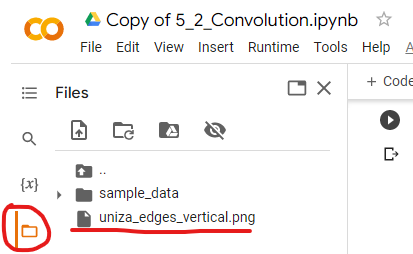

How does this kernel help detect vertical edges?  
The kernel computes the **difference between pixels on the right and pixels on the left**.  
If this difference is large, it indicates a strong change in intensity — which likely corresponds to an **edge**.

See the example below, where we convolve a simple matrix with the kernel to visualize how it highlights vertical transitions in pixel values.


In [ ]:
# create a simple matrix
b = np.array([0.11, 0.15, 0.1, 0.3, 0.5, 0.7, 0.7, 0.65, 0.63, 0.62])
A = np.ones((b.shape[0], b.shape[0])) * b
print(f"Entry matrix:\n{A}" )
print(f"Result of the convolution: \n{convolve(A, vertical_edge_kernel)}")

Notice, that the cells where the change compared other is the highest, got the highest value in the convolved matrix.

### A Vectorized Version of Convolution

The convolution code above contains multiple nested loops, which makes it slow when applied to large images.  
To improve performance, you can **vectorize** the elementwise multiplication of the matrices.  

To handle the boundary indices (edges of the image), you can **pad** the original matrix with an appropriate border of zeros (or other padding values).  
This allows the kernel to slide over the entire image without going out of bounds, while maintaining the correct output size.


In [ ]:
#@title Vectorised code
def convolve_vectorized(A, B):
    # flips the filter for easier multiplication
    B = np.flip(B, (0,1))
    # Initialize dimensions sizes as in mathematical formula
    m, n = A.shape
    p, q = B.shape
    # Initialize the dimensions of the result matrix
    r = m + p - 1
    s = n + q - 1
    C = np.zeros((r,s))
    # Pad the original matrix
    b_0 = int(np.ceil(B.shape[0] / 2))
    b_1 = int(np.ceil(B.shape[1] / 2))
    A_p = np.pad(A, ((b_0,b_0), (b_1,b_1)))

    # Perform the convolution
    for i in range(m+1):
      for j in range(n+1):
        C[i:(i+p), j:(j+q)] = np.sum(A_p[(i):(i+p), (j):(j+q)] * B)
    return C

### Kernel for Horizontal Edges

Above, you saw the kernel used for detecting **vertical edges**.  
What do you think the kernel for detecting **horizontal edges** might look like?  

Try to create such a kernel yourself — think about how the pixel differences should be computed (top vs. bottom) to highlight horizontal transitions.  

The answer is shown two cells below — click *“Show code”* to reveal it.


In [ ]:
horizontal_edge_kernel = # define the kernel for horizontal edge detection

img_mat = convolve_fast(img_array_gs , horizontal_edge_kernel)
display(img_mat, save ="uniza_edges_horizontal")

In [ ]:
#@title Horizontal edge kernel { display-mode: "form" }
horizontal_edge_kernel = vertical_edge_kernel.T
# print(horizontal_edge_kernel)

### Blurring Kernel

In the example from the *VMLS* book, the kernel computed the **average of a pixel and its three neighboring pixels**.  
Now, try to create a **$3 \times 3$ kernel** that computes the average of a pixel and **all its surrounding neighbors** — including diagonal ones.  

Applying convolution with this kernel should produce a **blurred** version of the image.  
Similar to the $2 \times 2$ kernel from *VMLS*, all elements of this kernel will have the same value.

You can also experiment with a **$5 \times 5$ kernel** to achieve an even stronger blurring effect.


In [ ]:
blurring_kernel = # add your code here
img_mat = convolve_vectorized(img_array_gs , blurring_kernel)
display(img_mat, "blurred_image")

Answer is below:

In [ ]:
#@title Blurring kernel
blurring_kernel = np.ones((3,3))/9
blurring_kernel_5_5 = np.ones((5,5))/25

### Sharpening Kernel

A **sharpening kernel** enhances the differences between adjacent pixel values, making edges more pronounced and the image appear sharper and more vivid.  
It effectively increases contrast around edges by highlighting intensity changes between neighboring pixels.


In [ ]:
sharpening_kernel = np.array([[0, 1, 0],[1, 5, 1],[0, 1 ,0]])
print(f"Sharpening kernel:\n{sharpening_kernel}")
img_mat = convolve_vectorized(img_array_gs , sharpening_kernel)
display(img_mat, "sharpened_image")

We can better observe the effect of **sharpening** by comparing zoomed-in images.  
The **upper image** shows the original version, while the **lower image** displays the sharpened version.  
Notice how edges and fine details appear more distinct and pronounced in the sharpened image.


In [ ]:
image_centre = img_array_gs[64:(img_array_gs.shape[0]-63),64:(img_array_gs.shape[0]-63)]
img_mat = convolve_vectorized(image_centre , sharpening_kernel)
display(image_centre)
display(img_mat)

You can read more about convolution filters [here](https://sbme-tutorials.github.io/2018/cv/notes/4_week4.html).